Comparing the waveforms of each detection of a template

In [1]:
import pandas as pd
import numpy as np
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from time import time
from obspy.signal.trigger import recursive_sta_lta, classic_sta_lta, plot_trigger
import csv

# from pnwstore.mseed import WaveformClient
# from obspy.core.utcdatetime import UTCDateTime

# client = WaveformClient()
client2 = Client('IRIS')

In [39]:
read = pd.read_csv('Hood_BRSP_DEC_2020_detections.csv')

In [131]:
#parameters
ta = 20 #time in seconds after detection time
# 13 because the templates are 13 seconds long + 10 extra seconds
tb = 10 #time in seconds before detection time
# 10 because there's a 10 second weird thing when finding the signal
fs = 40 #sampling rate
fqmin = 1 #minimum frequency for bandpass filter
fqmax = 10 #maximum frequency for bandpass filter
cl_list = [2,6,8,10] # list of cluster ids that have templates 
#TO DO: try to save cid from Make_Templates and use it for cl_list
cl_range_st = 0 #first number in range of cluster ids to try
cl_range_en = 5 #last number in range of cluster ids to try
thr_on = 1.35 #threshold to turn the signal trigger on
thr_off = 0.75 #threshold to turn the signal trigger off
station = 'BRSP' #station to run
chan_ = 'bhz' #channel as it appears in the template name
chan = '*HZ' #channel to run
nsta = 5. #length of short window for signal detection in seconds
nlta = 10. #length of long window for signal detection in seconds
pr = 98 #percentile for SNR

In [116]:
times = read[read['Template_Name'] == 'brspbhzrpho10']['Detection_Time'].values.tolist()
#volc_md[volc_md['Volcano_Name'] == 'Mt_Baker']['Station'].values.tolist()
# print(times)
for ii,i in enumerate(times):
    print(type(i))
    break

<class 'str'>


plotting all (unshifted) redpy detections for a cluster (may need to import some things to run this, but it works on Make_Templates

In [ ]:
plt.figure(figsize=(8,10))
cl = 152
sta = 'VDB'
net = 'CN'
sst=obspy.Stream() #sst will have every trace for each cluster
print('------------') #divider for clarity
print('Cluster ID: '+str(cl)+' Volcano: '+volc_list_names[vv]+' Station: '+sta+' Network: '+net) #keeping track of what is currently running
for ii,i in enumerate(volc_list[vv][volc_list[vv]['Clustered'] == cl]['datetime']): #i is each datetime from cl at this volcano
    print(i)
    stt=UTCDateTime(i)-tb-nlta #starttime
    et=UTCDateTime(i)+ta #endtime
    utct=UTCDateTime(i) #datetime from REDpy catalog
    try:
        st = client.get_waveforms(network=net,station=sta,location='*',
                                  channel=chan, year=utct.year, doy=utct.julday)
        st = st.detrend(type = 'demean')
        st.filter(type='bandpass',freqmin=fqmin,freqmax=fqmax)
        st.resample(fs) #get same sampling rate for all events
        st.trim(starttime=stt,endtime=et)
        st.merge(fill_value = 0)
    except:
        print('Could not find waveform')
        continue #if no waveform can be found, move onto next time
    if len(st)==0:
        print('no data for this time')
        continue
    print(len(st[0].data))
    if len(st[0].data) != round((ta+tb+nlta)*fs)+1: #if there is enough data to contribute to making a stack
        continue
    plt.plot(st[0].data[:]/np.max(np.abs(st[0].data))+2*ii)

Plotting waveforms to compare visually

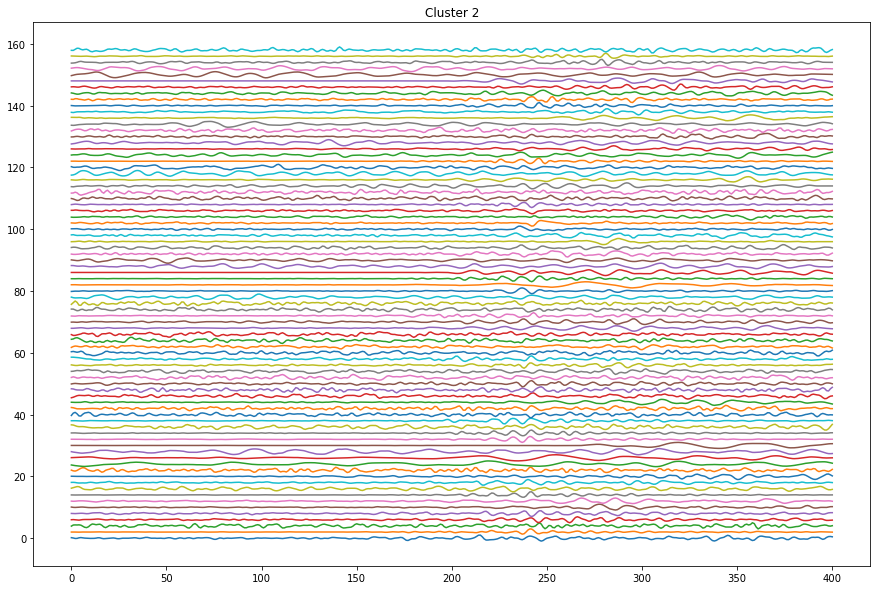

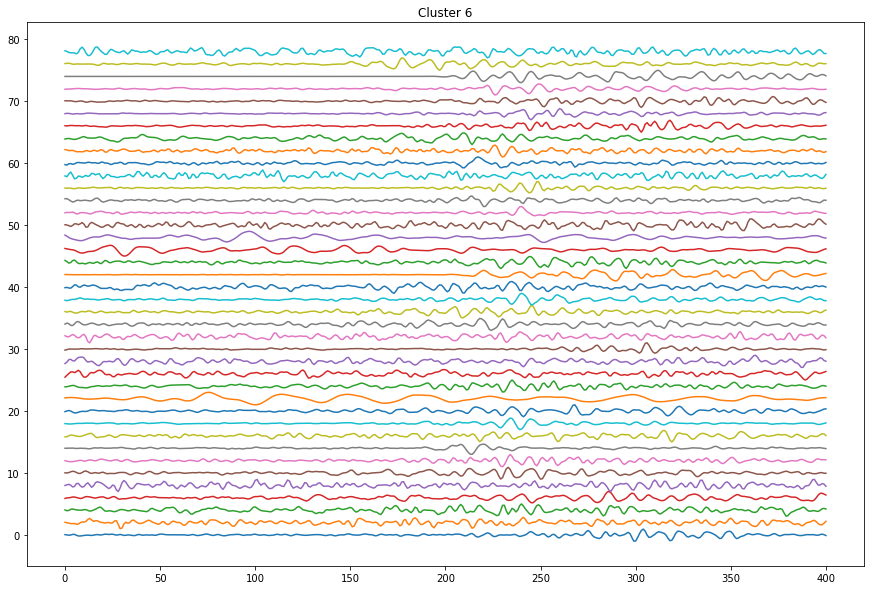

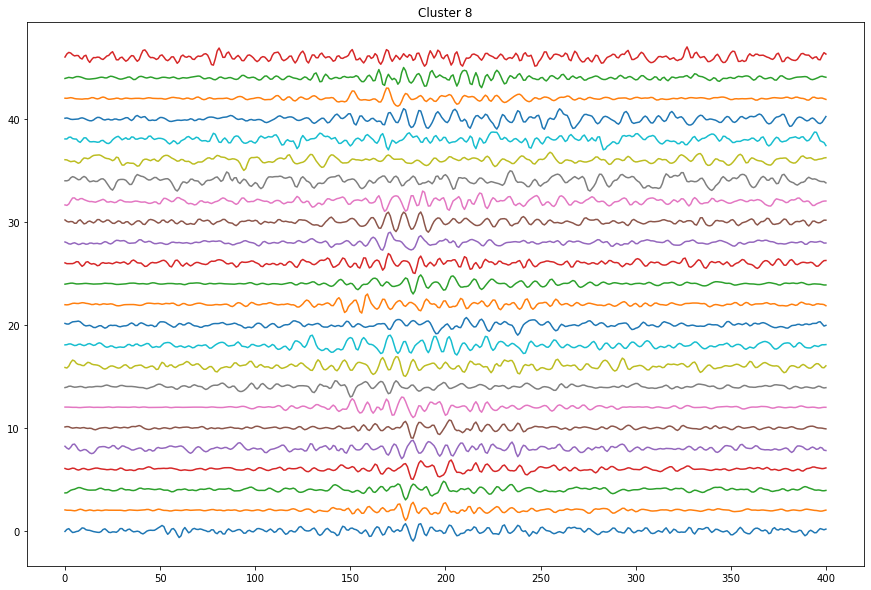

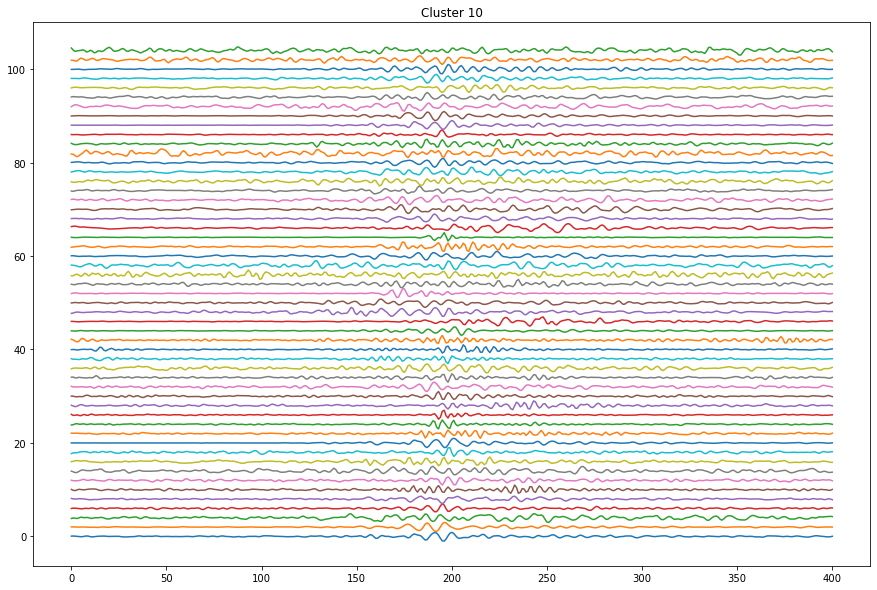

In [61]:
# ta = 10 #time in seconds after detection time/length of window
# fs = 40 #sampling rate
# fqmin = 1 #minimum frequency for bandpass filter
# fqmax = 10 #maximum frequency for bandpass filter
# list = [2,6,8,10] # list of cluster ids that have templates

# TB NOT INTEGRATED

for cl in cl_list:
    times = read[read['Template_Name'] == 'brspbhzrpho'+str(cl)]['Detection_Time'].values.tolist()
    
    fig = plt.figure(figsize=(15,10))
    for ii,i in enumerate(times):
        et=UTCDateTime(i)+ta
        utct=UTCDateTime(i)
#         print(ii,i)
        st = client.get_waveforms(network='*',station='BRSP',location='*',channel='*HZ',
                                  year=utct.year,month=utct.month,day=utct.day)
        st.filter(type='bandpass',freqmin=fqmin,freqmax=fqmax)
        st.resample(fs)
        st.trim(starttime=utct,endtime=et)
        st.merge(fill_value = 0)
        if len(st)==0: continue
        plt.plot(st[0].data[:]/np.max(np.abs(st[0].data))+2*ii)
        plt.title('Cluster '+str(cl))


Compare waveforms once detections are cleaned up

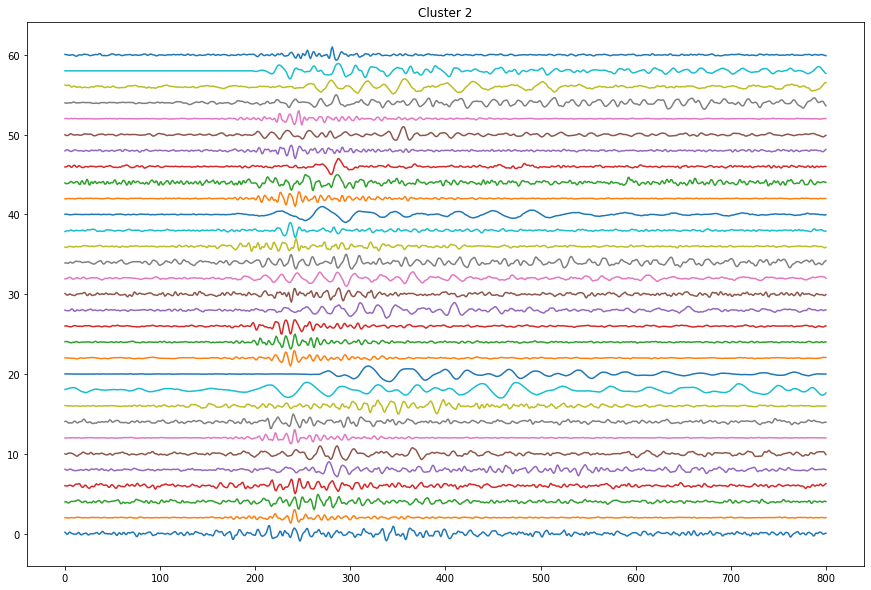

In [140]:
read = pd.read_csv('brspbhzrpho0002_detection_trigger_times.csv')

times = read['Detection_Time'].values.tolist()
trigs = read['Trigger_on'].values.tolist()

fig = plt.figure(figsize=(15,10))
for ii,i in enumerate(times):
    utct=UTCDateTime(i)#+trigs[ii]-2
    et=UTCDateTime(i)+20
#         print(ii,i)
    st = client.get_waveforms(network='*',station='BRSP',location='*',channel='*HZ',
                              year=utct.year,month=utct.month,day=utct.day)
    st.filter(type='bandpass',freqmin=fqmin,freqmax=fqmax)
    st.resample(fs)
    st.trim(starttime=utct,endtime=et)
#     st.merge(fill_value = 0)
    if len(st)==0: continue
    plt.plot(st[0].data[:]/np.max(np.abs(st[0].data))+2*ii)
    plt.title('Cluster 2')

In [23]:
utct=UTCDateTime(times[0])
print(utct)
# print(dir(utct))
print(utct.year,utct.month,utct.day,utct.hour,utct.minute,utct.second)
print(utct.time)
print( )
print(str(utct.hour).zfill(3))

2020-12-01T14:19:43.350000Z
2020 12 1 14 19 43
14:19:43.350000

014


### Finding signal, then only keeping detections with a high enough signal to noise ratio

Finding the signal - Saving trigger times in a csv file - Jul 14, 2022

In [ ]:
# cl_list = [8] # SET HERE FOR THE PURPOSE OF TESTING, NOT PERMANENT
for cl in cl_list:
    times = read[read['Template_Name'] == station.lower()+chan_+'rpho'+str(cl)]['Detection_Time'].values.tolist()
#     with open(station.lower()+chan_+'rpho'+str(cl)+'_detection_trigger_times.csv', 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(["Detection_Time", "Trigger_on", "Trigger_off"])
#         file.close()
#     fig = plt.figure(figsize=(15,10))
    for ii,i in enumerate(times):
        et=UTCDateTime(i)+ta
        utct=UTCDateTime(i)-tb
        st = client.get_waveforms(network='*',station=station,location='*',channel=chan,
                                  year=utct.year,month=utct.month,day=utct.day)
        st.filter(type='bandpass',freqmin=fqmin,freqmax=fqmax)
        st.detrend(type='demean')
        st.resample(fs)
        st.trim(starttime=utct,endtime=et)
        st.merge(fill_value = 0)
        if len(st)==0: continue
# classic
        try:
            cft = classic_sta_lta(st[0].data, int(nsta * fs), int(nlta * fs))
            print('-------------')
            print('detection: '+str(ii),'cluster id: '+str(cl))
            plot_trigger(st[0], cft, thr_on, thr_off)
            on_off = np.array(trigger_onset(cft, thr_on, thr_off))
#             print('Trigger On:',on_off[:, 0] / fs)
#             print('Trigger Off:',on_off[:, 1] / fs)
#             print( )
#             print('Trigger on',float(on_off[:, 0] / fs)-tb,'seconds after detect time')
            # show trigger on and off times, rounded to 4 decimal places
            trig_on = round(float(on_off[:, 0] / fs)-tb,4)
            trig_off = round(float(on_off[:, 1] / fs)-tb,4)
            print('Trigger on',trig_on,'seconds after detect time')
            print('Trigger off',trig_off,'seconds after detect time')
#             row = [i,
#                    round(float(on_off[:, 0] / fs)-tb,4),
#                    round(float(on_off[:, 1] / fs)-tb,4)]
#             # automatically filters out detections that it can't find a signal for
#             with open(station.lower()+chan_+'rpho'+str(cl)+'_detection_trigger_times.csv', 'a', newline='') as file:
#                 writer = csv.writer(file)
#                 writer.writerow(row)
#                 file.close()
        except:
            print('detection: '+str(ii),'cluster id: '+str(cl)+' NOT FOUND')

        
# recursive
#         try:
#             cft = recursive_sta_lta(st[0].data, int(5. * fs), int(10. * fs))
#             print('detection: '+str(ii),'cluster id: '+str(cl))
#             plot_trigger(st[0], cft, 1.5, 1.)        
#         except:
#             print('detection: '+str(ii),'cluster id: '+str(cl)+' NOT FOUND')        
        
#         plt.plot(st[0].data[:]/np.max(np.abs(st[0].data))+2*ii)
#         plt.title('Cluster '+str(cl))
#         break
    break

In [ ]:
read1 = pd.read_csv('brspbhzrpho8_detection_trigger_times.csv')
times1 = read1['Detection_Time'].values.tolist()
on = read1['Trigger_on'].values.tolist()
off = read1['Trigger_off'].values.tolist()

# for i in range(0,len(on)):
#     print(i,times[i],on[i],off[i])

print(read1)    

Finding SNR

In [ ]:
# For Reference
SNR = []
signal_window = x.copy()
noise_window = x.copy()
signal_window.trim(starttime=i+, starttime+t_before-1+window)
noise_window.trim(starttime-window+t_before-10, starttime+t_before-10)

#print(len(x.data), len(signal_window.data), len(noise_window.data))
SNR.append(20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
           / np.percentile(np.abs(noise_window.data),pr))/np.log(10))

### Most Recent/Updated Cell Below

In [ ]:
# SNR based on Francesca's code: https://github.com/Denolle-Lab/pnw_exotic_event_project/blob/main/notebooks/Make_Event_Catalog.ipynb
# cl_list = [8] # SET HERE FOR THE PURPOSE OF TESTING, NOT PERMANENT

#eventually integrate reading multiple detection files
# read = pd.read_csv('Hood_BRSP_DEC_2020_detections.csv')

for cl in cl_list:
    times = read[read['Template_Name'] == station.lower()+chan_+'rpho'+str(cl)]['Detection_Time'].values.tolist()
    with open(station.lower()+chan_+'rpho'+str(cl).zfill(4)+ #not doing the zfill?
              '_detection_trigger_times.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Detection_Time", "Trigger_on", "Trigger_off","SNR"])
        file.close()
    for ii,i in enumerate(times):
        et=UTCDateTime(i)+ta
        stt=UTCDateTime(i)-tb
        utct=UTCDateTime(i)
        st = client.get_waveforms(network='*',station=station,location='*',channel=chan,
                                  year=utct.year,month=utct.month,day=utct.day)
        st.filter(type='bandpass',freqmin=fqmin,freqmax=fqmax)
        st.detrend(type='demean')
        st.resample(fs)
        st.trim(starttime=stt,endtime=et)
        st.merge(fill_value = 0)
        if len(st)==0: continue
# classic
        try:
            cft = classic_sta_lta(st[0].data, int(nsta * fs), int(nlta * fs))
            print('-------------')
            print('detection: '+str(ii),'cluster id: '+str(cl))
            plot_trigger(st[0], cft, thr_on, thr_off)
            on_off = np.array(trigger_onset(cft, thr_on, thr_off))
            # show trigger on and off times, rounded to 4 decimal places
            trig_on = round(float(on_off[:, 0] / fs)-tb,4)
            trig_off = round(float(on_off[:, 1] / fs)-tb,4)
            print('Trigger on',trig_on,'seconds after detect time')
            print('Trigger off',trig_off,'seconds after detect time')

            signal_window = st[0].copy()
            noise_window = st[0].copy()

            signal_window.trim(starttime=UTCDateTime(i)+trig_on-0.5,endtime=UTCDateTime(i)+trig_off) 
            #i+trig_on-0.5 to include lead up to the signal
            noise_window.trim(starttime=UTCDateTime(i)-10,endtime=UTCDateTime(i))

            snr = 20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                              / np.percentile(np.abs(noise_window.data),pr))/np.log(10)
            if snr>7.:
                row = [i,trig_on,trig_off,snr]
                # automatically filters out detections that it can't find a signal for
                with open(station.lower()+chan_+'rpho'+str(cl).zfill(4)+'_detection_trigger_times.csv', 'a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(row)
                    file.close()
        except:
            print('NOT FOUND')

#         break
    break

In [ ]:
print(pd.read_csv('brspbhzrpho8_detection_trigger_times.csv'))
print(pd.read_csv('brspbhzrpho2_detection_trigger_times.csv'))

Loop through multiple files

### Random Testing Below Here

Ar pick

In [30]:
from obspy.core import read
from obspy.signal.trigger import ar_pick
tr1 = read('https://examples.obspy.org/loc_RJOB20050801145719850.z.gse2')[0]
tr2 = read('https://examples.obspy.org/loc_RJOB20050801145719850.n.gse2')[0]
tr3 = read('https://examples.obspy.org/loc_RJOB20050801145719850.e.gse2')[0]
df = tr1.stats.sampling_rate
p_pick, s_pick = ar_pick(tr1.data, tr2.data, tr3.data, df,
                         1.0, 20.0, 1.0, 0.1, 4.0, 1.0, 2, 8, 0.1, 0.2)
print(p_pick)
# 30.6350002289
print(s_pick)
# 31.2800006866

# NEEDS Z N AND E

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/obspy/io/gse2/libgse2.py:325: UserWarning: Checksum differs only in absolute value. If this file was written with ObsPy GSE2, this is due to a bug in the obspy.io.gse2.write routine (resolved with [3431]), and thus this message can be safely ignored.
  warnings.warn(msg, UserWarning)


30.635000228881836
31.165000915527344


Below seems to work well enough, but only picktimes, not trigger off times, also the picktimes seem inconsistent with the classic sta lta trigger ons. 

In [ ]:
list = [8]#[2,6,8,10]

for cl in cl_list:
    times = read[read['Template_Name'] == 'brspbhzrpho'+str(cl)]['Detection_Time'].values.tolist()
    
#     fig = plt.figure(figsize=(15,10))
    for ii,i in enumerate(times):
        sst = obspy.Stream()
        for ch in ['*HZ','*HN','*HE']:
            et=UTCDateTime(i)+ta
            utct=UTCDateTime(i)-tb
            st = client.get_waveforms(network='*',station='BRSP',location='*',channel=ch,
                                      year=utct.year,month=utct.month,day=utct.day)
            st.filter(type='bandpass',freqmin=fqmin,freqmax=fqmax)
    #         st.detrend(type='demean')
            st.resample(fs)
            st.trim(starttime=utct,endtime=et)
            st.merge(fill_value = 0)
            sst.append(st[0])
        print( )
        print(sst)
        print('detection: '+str(ii),'cluster id: '+str(cl))
        if len(sst)<3: continue
        p_pick, s_pick = ar_pick(sst[0].data, sst[1].data, sst[2].data, fs,
                         1.0, 20.0, 1.0, 0.1, 4.0, 1.0, 2, 8, 0.1, 0.2)
        print(p_pick)
#         break
#     break

Classic & Recursive sta lta - July 13, 2022

In [ ]:
dir(plot_trigger)

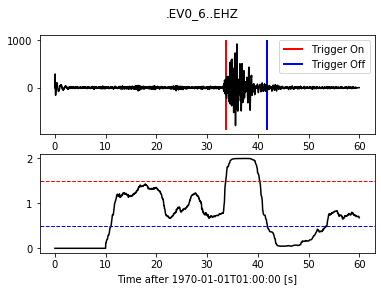

Trigger On: [ 33.68]
Trigger Off: [ 41.875]

Trigger on 23.68 seconds after detect time
Trigger on 31.875 seconds after detect time


In [68]:
# import obspy
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset


trace = obspy.read("https://examples.obspy.org/ev0_6.a01.gse2")[0]
df = trace.stats.sampling_rate # we resample all of the streams in line 11 on cell below, so df=fs

cft = classic_sta_lta(trace.data, int(5. * df), int(10. * df))
plot_trigger(trace, cft, 1.5, 0.5)

#Source code: https://docs.obspy.org/_modules/obspy/signal/trigger.html

on_off = np.array(trigger_onset(cft, 1.5, 0.5))
print('Trigger On:',on_off[:, 0] / df)
print('Trigger Off:',on_off[:, 1] / df)
print( )
print('Trigger on',float(on_off[:, 0] / df)-tb,'seconds after detect time')
print('Trigger on',float(on_off[:, 1] / df)-tb,'seconds after detect time')


In [ ]:
cft = classic_sta_lta(trace.data, int(5. * fs), int(10. * fs))
plot_trigger(st[0], cft, 1.5, 0.5)

In [44]:
from obspy.signal.trigger import recursive_sta_lta
cft = recursive_sta_lta(trace.data, int(5 * df), int(10 * df))
plot_trigger(trace, cft, 1.2, 0.5)

In [50]:
help(classic_sta_lta)

Help on function classic_sta_lta in module obspy.signal.trigger:

classic_sta_lta(a, nsta, nlta)
    Computes the standard STA/LTA from a given input array a. The length of
    the STA is given by nsta in samples, respectively is the length of the
    LTA given by nlta in samples.
    
    Fast version written in C.
    
    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of short time average window in samples
    :type nlta: int
    :param nlta: Length of long time average window in samples
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Characteristic function of classic STA/LTA



In [63]:
print(len(times))

81


Carl sta trig - July 12, 2022

In [46]:
from obspy.signal.trigger import carl_sta_trig
cft = carl_sta_trig(trace.data, int(5 * df), int(10 * df), 0.8, 0.8)
plot_trigger(trace, cft, 20.0, -20.0)

<Figure size 1080x720 with 0 Axes>

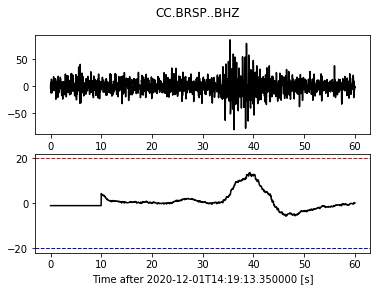

<Figure size 1080x720 with 0 Axes>

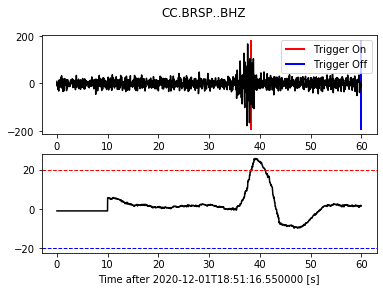

<Figure size 1080x720 with 0 Axes>

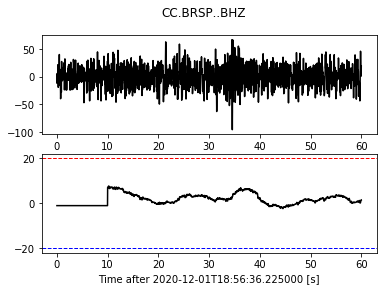

<Figure size 1080x720 with 0 Axes>

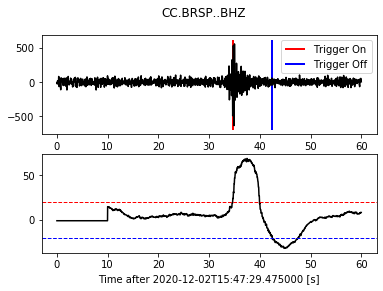

In [52]:
for cl in cl_list:
    times = read[read['Template_Name'] == 'brspbhzrpho'+str(cl)]['Detection_Time'].values.tolist()
    
    fig = plt.figure(figsize=(15,10))
    for ii,i in enumerate(times):
        et=UTCDateTime(i)+ta
        utct=UTCDateTime(i)-tb
#         print(ii,i)
        st = client.get_waveforms(network='*',station='BRSP',location='*',channel='*HZ',
                                  year=utct.year,month=utct.month,day=utct.day)
        st.filter(type='bandpass',freqmin=fqmin,freqmax=fqmax)
        st.resample(fs)
        st.trim(starttime=utct,endtime=et)
        st.merge(fill_value = 0)
        
        cft = carl_sta_trig(st[0].data, int(5 * fs), int(10 * fs), 0.8, 0.8)
        plot_trigger(st[0], cft, 20.0, -20.0)
        
        if len(st)==0: continue
#         plt.plot(st[0].data[:]/np.max(np.abs(st[0].data))+2*ii)
#         plt.title('Cluster '+str(cl))
        break
#     break


DIY way - Jul 12, 2022

In [ ]:
for cl in cl_list:
    times = read[read['Template_Name'] == 'brspbhzrpho'+str(cl)]['Detection_Time'].values.tolist()
    
    fig = plt.figure(figsize=(15,10))
    for ii,i in enumerate(times):
        et=UTCDateTime(i)+ta
        utct=UTCDateTime(i)
        st = client.get_waveforms(network='*',station='BRSP',location='*',channel='*HZ',
                                  year=utct.year,month=utct.month,day=utct.day)
        st.filter(type='bandpass',freqmin=fqmin,freqmax=fqmax)
        st.resample(fs)
        st.trim(starttime=utct,endtime=et)
        st.merge(fill_value = 0)  
        print('Got and filtered waveforms')
        if len(st)==0: continue
#         print('Y is forming')
        Y = np.cumsum(np.abs(st[0].data**2))

    
#         Y2 = np.abs(st[0].data)
#         print('Y has formed')
#         print(Y)

#         plt.plot(st[0].data[:]/np.max(np.abs(st[0].data))+2*ii)
#         plt.title('Cluster '+str(cl))
        print(Y.any())

#         if round(Y.any()) == round(0.02*Y[-1]):
#             print(Y.any())
        
        
#         pick_time = 0.02*Y2[-1]
#         end_time = 0.95*Y2[-1]
        
    
#         pick_time = 
#         end_time = 
        
#         plt.hlines(pick_time, xmin=0, xmax = 400)
#         plt.hlines(end_time, xmin=0, xmax = 400,color='blue')
        
#         plt.vlines(pick_time/Y2, ymin=-2, ymax = 2)
#         plt.vlines(end_time/Y2, ymin=-2, ymax = 2)

    
        break
    break


In [ ]:
print(st[0].data)

testing some loop stuff for make_templates July 13, 2022

In [ ]:
for s in range(0,2):
    list = []
    for cl in range(0,5):
        print(s, cl)
    print('Yeah!')
    for i in range(0,3):
        print(i)
    print( )

In [54]:
for i in range(0, 0):
    print('Working on shifting')

In [55]:
sst = []
print(len(sst))

0


In [ ]:
# line 54
if len(sst)<2: continue # When I move this line further up, it stops even more of the code for if sst is 0
    
    # could it be only allowing 1 and 2 to go through?


In [57]:
print(str(len(sst)))

0


In [59]:
list = [2,6,8,10]
for ii in list:
    print(ii)

2
6
8
10


In [7]:
# continue should only skip the rest of the loop it's directly in, 
# not the loop that it's loop is inside of
for s in range(0,5):
    for c in range(2,5):
        if s == 3: continue
        print(s,c)
    print( )
    print(s)
    print( )
        

0 2
0 3
0 4

0

1 2
1 3
1 4

1

2 2
2 3
2 4

2


3

4 2
4 3
4 4

4

